In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.utils import parallel_backend
import torch
from ctgan import CTGAN

In [3]:
df = pd.read_csv('engine_data.csv')

In [4]:
has_na = df.isna().any().any()

# Get the count of missing values in each column
missing_values_count = df.isna().sum()

# Display the results
print(f"Does the dataset have any missing values? {has_na}")
print("Count of missing values in each column:")
print(missing_values_count[missing_values_count > 0]) 

Does the dataset have any missing values? False
Count of missing values in each column:
Series([], dtype: int64)


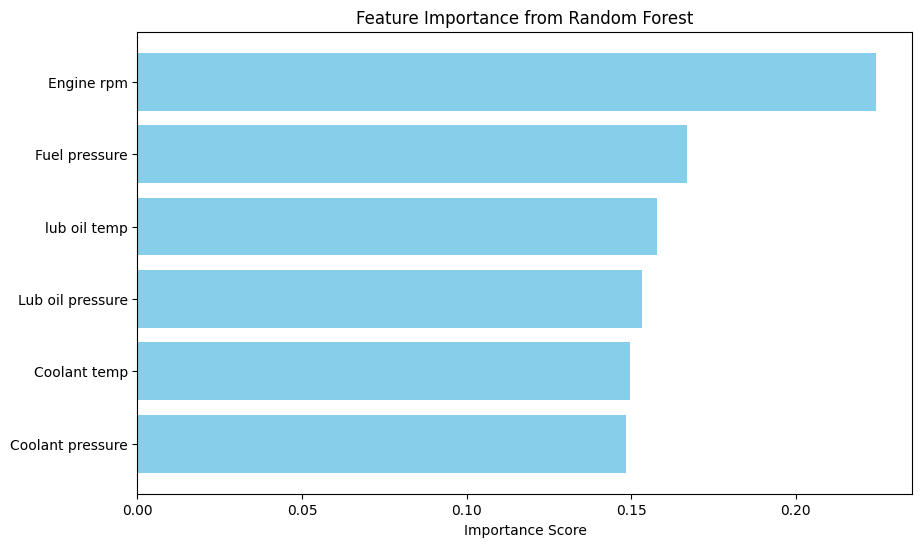

Top 4 features by importance:
            Feature  Importance
0        Engine rpm    0.224203
2     Fuel pressure    0.166938
4      lub oil temp    0.157740
1  Lub oil pressure    0.153127
5      Coolant temp    0.149587
3  Coolant pressure    0.148405


In [5]:
# Assuming 'df' is your DataFrame and 'target' is the column name for the target variable
X = df.drop('Engine Condition', axis=1)  # Features
y = df['Engine Condition']  # Target variable

# Step 2: Split the data into training and testing sets (if needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Step 4: Extract feature importances
importances = rf_model.feature_importances_

# Step 5: Create a DataFrame for visualization
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Step 6: Visualize the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features on top
plt.show()

# Show top 4 features
print("Top 4 features by importance:")
print(feature_importances)

In [6]:
correlation = df.corr()["Engine rpm"].drop("Engine rpm")
correlation

Lub oil pressure    0.025046
Fuel pressure      -0.001571
Coolant pressure   -0.024979
lub oil temp        0.052134
Coolant temp        0.029560
Engine Condition   -0.268201
Name: Engine rpm, dtype: float64

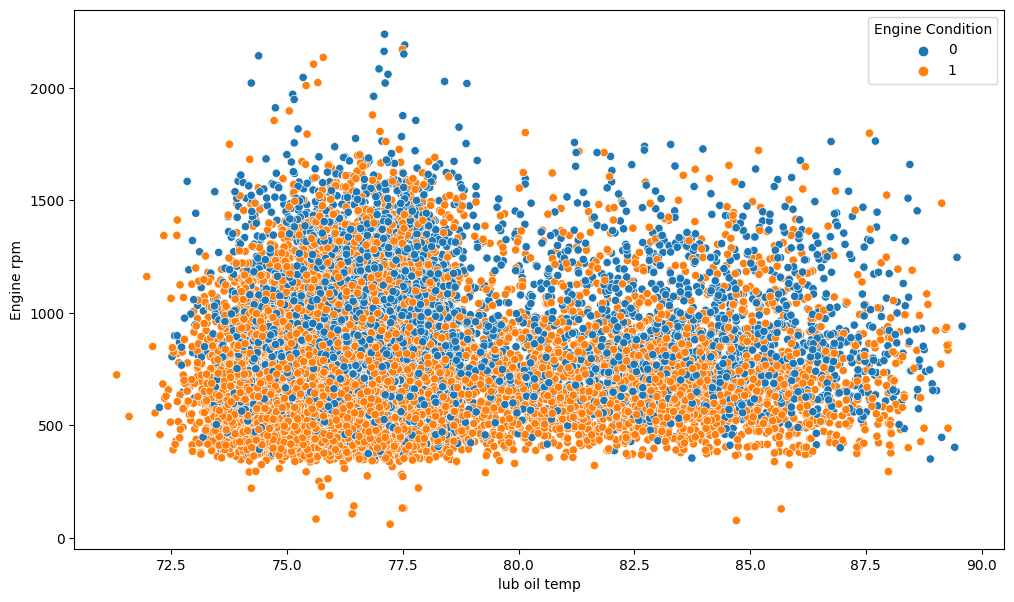

In [7]:
plt.figure(figsize=(12,7))
sns.scatterplot(data=df, y='Engine rpm', x='lub oil temp', hue='Engine Condition')
plt.show()

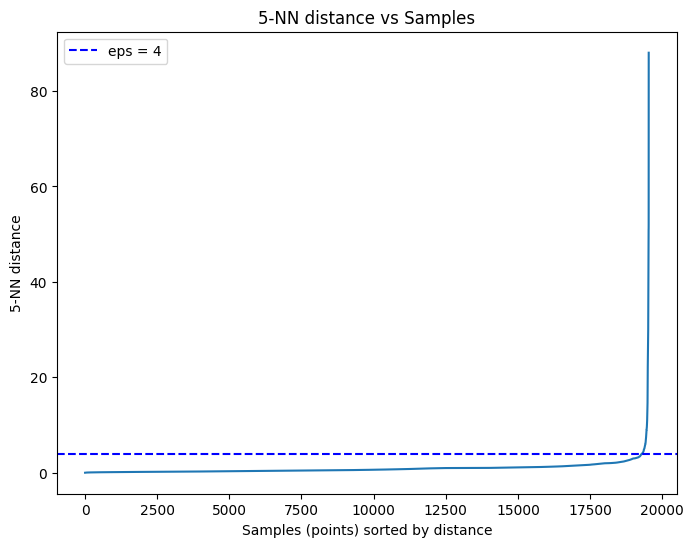

In [8]:
from sklearn.neighbors import NearestNeighbors

# Assuming 'df' is your DataFrame and you want to use 'Engine rpm' and 'lub oil temp' columns
data = df[['Engine rpm', 'lub oil temp']].dropna().values  # Drop any rows with NaN values

# Set k for the k-distance plot (usually 5)
k = 5
nearest_neighbors = NearestNeighbors(n_neighbors=k)
nearest_neighbors.fit(data)
distances, indices = nearest_neighbors.kneighbors(data)

# Sort the distances to the k-th nearest neighbor for each point
k_distances = np.sort(distances[:, k - 1])

# Plot the k-distance graph
plt.figure(figsize=(8, 6))
plt.plot(k_distances)
plt.axhline(y=4, color='b', linestyle='--', label='eps = 4')
plt.title(f'{k}-NN distance vs Samples')
plt.xlabel('Samples (points) sorted by distance')
plt.ylabel(f'{k}-NN distance')
plt.legend()
plt.show()


In [9]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np

# Assuming df is your DataFrame and you want to use 'age' and 'trestbps' columns for clustering
X = df[['Engine rpm', 'lub oil temp']].values  # Extract relevant features

# Apply DBSCAN
dbscan = DBSCAN(eps=4, min_samples=5)
clusters = dbscan.fit_predict(X)

# Add the cluster labels to the DataFrame
df['cluster'] = clusters

# Identify outliers
outliers = clusters == -1

# Count outliers
num_outliers = np.sum(outliers)

print(f'Number of outliers detected: {num_outliers}')

Number of outliers detected: 157


Number of outliers detected: 157


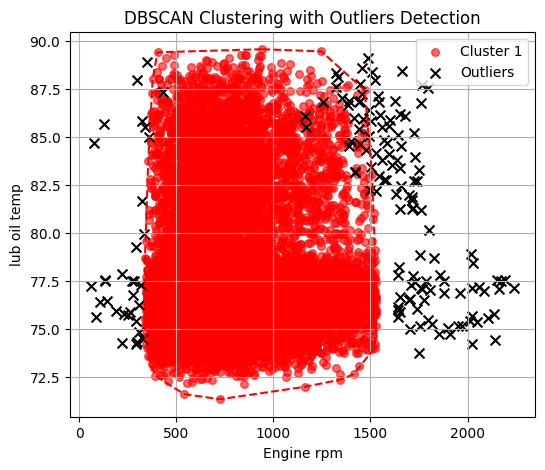

In [10]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np

# Assuming df is your DataFrame and you want to use 'Engine rpm' and 'lub oil temp' columns for clustering
X = df[['Engine rpm', 'lub oil temp']].values    # Extract relevant features

# Apply DBSCAN
dbscan = DBSCAN(eps=4, min_samples=5)  # Adjust eps as needed based on your data scale
clusters = dbscan.fit_predict(X)

# Add the cluster labels to the DataFrame
df['cluster'] = clusters

# Identify outliers
outliers = clusters == -1

# Count outliers
num_outliers = np.sum(outliers)
print(f'Number of outliers detected: {num_outliers}')

# Plotting
plt.figure(figsize=(6, 5))

# Plot points from Cluster 1 (DBSCAN assigns cluster numbers >= 0)
cluster_1 = df[df['cluster'] == 0]  # You can change '0' to any cluster number you want to highlight

# Scatter plot for cluster 1
plt.scatter(cluster_1['Engine rpm'], cluster_1['lub oil temp'], c='red', label='Cluster 1', alpha=0.6, s=30)

# Mark the outliers
plt.scatter(df['Engine rpm'][outliers], df['lub oil temp'][outliers], c='black', marker='x', label='Outliers', s=50)

# Plotting convex hull around the cluster points (Optional, just for visual appeal)
from scipy.spatial import ConvexHull
points = cluster_1[['Engine rpm', 'lub oil temp']].values
hull = ConvexHull(points)
hull_points = np.append(hull.vertices, hull.vertices[0])  # Closing the hull path
plt.plot(points[hull_points, 0], points[hull_points, 1], 'r--', lw=1.5)

# Adding labels and title
plt.xlabel('Engine rpm')
plt.ylabel('lub oil temp')
plt.legend(loc='best')
plt.grid(True)
plt.title('DBSCAN Clustering with Outliers Detection')

# Show the plot
plt.show()


In [11]:
# Assuming 'df' is your original DataFrame with the cluster information
original_count = len(df)  # Original number of entries

# Filter out the outliers (cluster = -1)
df_cleaned = df[df['cluster'] != -1].drop('cluster', axis=1)  # Drop the cluster column if you don't need it

# Count the cleaned dataset
cleaned_count = len(df_cleaned)  # Number of entries after cleaning

# Display the original and cleaned dataset counts
print(f'Original number of entries: {original_count}')
print(f'Number of entries after cleaning: {cleaned_count}')

# Display the cleaned dataset
print("\nCleaned dataset preview:")
print(df_cleaned.head())


Original number of entries: 19535
Number of entries after cleaning: 19378

Cleaned dataset preview:
   Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
0         700          2.493592      11.790927          3.178981   
1         876          2.941606      16.193866          2.464504   
2         520          2.961746       6.553147          1.064347   
3         473          3.707835      19.510172          3.727455   
4         619          5.672919      15.738871          2.052251   

   lub oil temp  Coolant temp  Engine Condition  
0     84.144163     81.632187                 1  
1     77.640934     82.445724                 0  
2     77.752266     79.645777                 1  
3     74.129907     71.774629                 1  
4     78.396989     87.000225                 0  


In [12]:
# Assuming 'df' is your DataFrame and 'target' is the column name for the target variable
X = df_cleaned.drop('Engine Condition', axis=1)  # Features
y = df_cleaned['Engine Condition']  # Target variable

# Step 2: Split the data into training and testing sets (if needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter


# Separate features and target variable
X = X_train # Features (all columns except the last one)
y = y_train   # Target variable (last column)

# Display original class distribution
print('Original class distribution:', Counter(y))

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train = X_resampled
y_train = y_resampled

# Display new class distribution
print('Resampled class distribution:', Counter(y_resampled))


Original class distribution: Counter({1: 9851, 0: 5651})
Resampled class distribution: Counter({1: 9851, 0: 9851})


In [14]:
import optuna
import lightgbm as lgb

# Objective function for hyperparameter tuning
def objective(trial):
    # Define the hyperparameters to tune
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.5),
        'num_leaves': trial.suggest_int('num_leaves', 10, 300),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 200),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 15),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 15),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 15)
    }
    
    # Train LightGBM model
    lgb_clf = lgb.LGBMClassifier(**param)
    lgb_clf.fit(X_train, y_train)

    # Make predictions and calculate accuracy
    y_pred = lgb_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Silence Optuna output
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Best hyperparameters
print("Best Hyperparameters:", study.best_params)

# Train with best parameters
best_params = study.best_params

lgb_clf = lgb.LGBMClassifier(**best_params)
lgb_clf.fit(X_train, y_train)

# Predictions and evaluation
y_pred = lgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best param: ", best_params)
print(f"Accuracy: {accuracy * 100:.2f}%")


c:\Users\nguye\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[LightGBM] [Warning] min_data_in_leaf is set=192, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=192
[LightGBM] [Warning] feature_fraction is set=0.5209149807592014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5209149807592014
[LightGBM] [Warning] lambda_l1 is set=4.8821624926763825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.8821624926763825
[LightGBM] [Warning] lambda_l2 is set=2.3508954980782084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3508954980782084
[LightGBM] [Warning] bagging_fraction is set=0.735587060423868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.735587060423868
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=192, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19

In [15]:
# Predictions and evaluation
y_pred = lgb_clf.predict(X_test)
y_pred_proba = lgb_clf.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Save the final model
lgb_final = lgb_clf

[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.8316923034722287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8316923034722287
[LightGBM] [Warning] lambda_l1 is set=14.100549601105989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14.100549601105989
[LightGBM] [Warning] lambda_l2 is set=8.728196122476401, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.728196122476401
[LightGBM] [Warning] bagging_fraction is set=0.3809313066662398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3809313066662398
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.8316923034722287, colsample_bytree=

[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.8316923034722287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8316923034722287
[LightGBM] [Warning] lambda_l1 is set=14.100549601105989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14.100549601105989
[LightGBM] [Warning] lambda_l2 is set=8.728196122476401, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.728196122476401
[LightGBM] [Warning] bagging_fraction is set=0.3809313066662398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3809313066662398
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


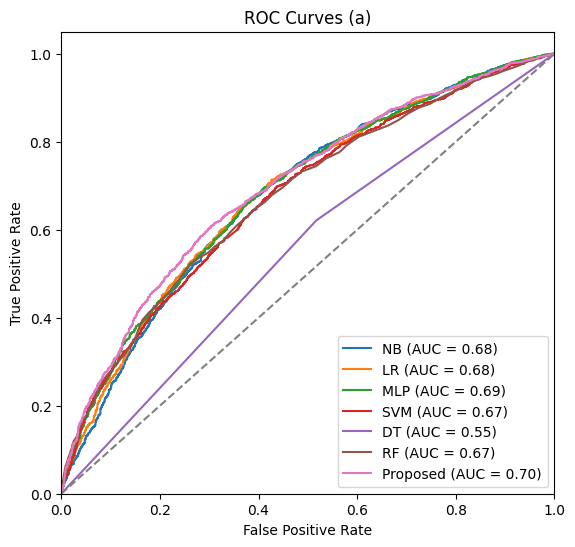

In [16]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming X_train, X_test, y_train, y_test are defined
# Example split if not done yet:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Naive Bayes
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)

# Train Logistic Regression
model_lr = LogisticRegression(solver='liblinear', random_state=42)
model_lr.fit(X_train, y_train)

# Train MLP (Neural Network)
model_mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
model_mlp.fit(X_train, y_train)

# Train Support Vector Machine
model_svm = SVC(probability=True, random_state=42)
model_svm.fit(X_train, y_train)

# Train Decision Tree
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train, y_train)

# Train Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Now proceed with the plotting as in the previous answer:
classifiers = {
    'NB': model_nb,     # Naive Bayes
    'LR': model_lr,     # Logistic Regression
    'MLP': model_mlp,   # Multilayer Perceptron
    'SVM': model_svm,   # Support Vector Machine
    'DT': model_dt,     # Decision Tree
    'RF': model_rf,     # Random Forest
    'Proposed': lgb_final  # Your proposed model
}

plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
for name, model in classifiers.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get the predicted probabilities for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (a)')
plt.legend(loc="lower right")

# # Subplot 2
# plt.subplot(1, 2, 2)
# for name, model in classifiers.items():
#     y_pred_proba = model.predict_proba(X_test)[:, 1]
#     fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curves (b)')
# plt.legend(loc="lower right")

# plt.tight_layout()
# plt.show()


In [17]:
# Calculate and print accuracy for each model
for name, model in classifiers.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{name} Accuracy: {accuracy:.2f}')

NB Accuracy: 0.65
LR Accuracy: 0.65
MLP Accuracy: 0.61
SVM Accuracy: 0.61
DT Accuracy: 0.57
RF Accuracy: 0.63
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.8316923034722287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8316923034722287
[LightGBM] [Warning] lambda_l1 is set=14.100549601105989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14.100549601105989
[LightGBM] [Warning] lambda_l2 is set=8.728196122476401, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.728196122476401
[LightGBM] [Warning] bagging_fraction is set=0.3809313066662398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3809313066662398
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Proposed Accuracy: 0.65


In [19]:
import time
import tracemalloc
import numpy as np

# List of models to evaluate
models = {
    'NB': model_nb,
    'LR': model_lr,
    'MLP': model_mlp,
    'SVM': model_svm,
    'DT': model_dt,
    'RF': model_rf,
    'Proposed': lgb_final
}

# Evaluate each model
for name, model in models.items():
    # Start tracking memory
    tracemalloc.start()
    start_time = time.time()

    # Perform inference
    model.predict(X_test)

    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Print results
    print(f"Model: {name}")
    print(f"Time: {end_time - start_time:.10f} sec")
    print(f"Used memory: {current / 1024:.2f} KB; Peak memory: {peak / 1024:.2f} KB")
    print("-" * 50)

Model: NB
Time: 0.0029032230 sec
Used memory: 2.76 KB; Peak memory: 643.52 KB
--------------------------------------------------
Model: LR
Time: 0.0030739307 sec
Used memory: 1.20 KB; Peak memory: 247.98 KB
--------------------------------------------------
Model: MLP
Time: 0.0031104088 sec
Used memory: 0.87 KB; Peak memory: 3275.96 KB
--------------------------------------------------
Model: SVM
Time: 3.7124485970 sec
Used memory: 2.00 KB; Peak memory: 365.73 KB
--------------------------------------------------
Model: DT
Time: 0.0024247169 sec
Used memory: 0.87 KB; Peak memory: 274.22 KB
--------------------------------------------------
Model: RF
Time: 0.0732369423 sec
Used memory: 5.29 KB; Peak memory: 312.33 KB
--------------------------------------------------
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.8316923034722287, colsample_bytree=1.0 will be ignored

[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.8316923034722287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8316923034722287
[LightGBM] [Warning] lambda_l1 is set=14.100549601105989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14.100549601105989
[LightGBM] [Warning] lambda_l2 is set=8.728196122476401, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.728196122476401
[LightGBM] [Warning] bagging_fraction is set=0.3809313066662398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3809313066662398
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


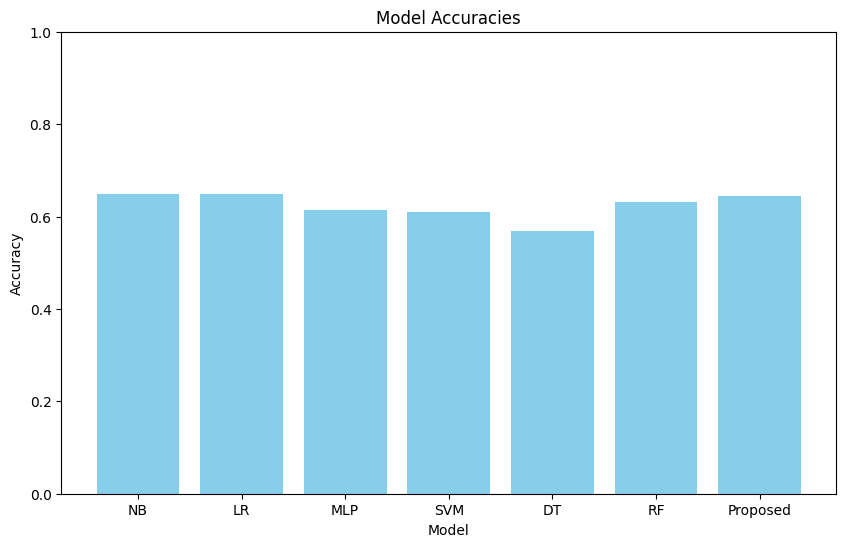

In [20]:
import matplotlib.pyplot as plt

# Extract model names and their accuracies
model_names = list(classifiers.keys())
accuracies = [accuracy_score(y_test, model.predict(X_test)) for model in classifiers.values()]

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.show()